# Deep Q-Network (DQN)

The two problems that consistently show up in the naive application of function approximation to RL (NFQ) are the **violations of the IID assumption** and the **non stationarity of targets**.

In supervised learning, we obtain a full dataset in advance. We pre-process it, shuffle it, and then split it into sets for training. One crucial step in this process is the **shuffling of the data set**. By doing so, we allow our optimization method to avoid developing overfitting biases, reduce the variance of the training process, speed up convergence, and overall learn a more general representation of the underlying data-generating process. In reinforcement learning data is **gathered online** (they come from a sequence, a time series, a trajectory) and the experience sample generated at time step t+1 correlates with the experience sample generated at time step t. Moreover, samples are not identically distributed, because they depend on the policy that generates the actions and the policy is changing through time (it improves).

Also, in supervised learning, the targets used for training are fixed values on our dataset (fixed throughout the training process). In reinforcement learning **targets move with every training step** of the network. At every training update step, we optimize the approximate value function and therefore change the shape of the function, possibly the entire value function. Changing the value function means that the target values change as well, which, in turn, means the targets used are no longer valid. Because the targets come from the network, even before we use them, we can assume targets are invalid or biased at a minimum.

<img src="./images/stationary-problem.png" width="600">

## Experience Replay

In NFQ, we use a mini-batch of N samples, and train the network with this batch for K iterations, alternating between calculating new targets and optimizing the network. These N samples are temporally correlated, because most of them belong to the same trajectory. **Experience replay** consists of a data structure (**replay memory**, called D) that **holds M>>N experience samples for several steps**, allowing the **sampling of mini-batches from a broad set of past experiences**. In that way, the training process can use a more diverse mini-batch for performing updates, and the agent no longer has to fit the model to the same small mini-batch for multiple iterations. The replay buffer **gives the impression that data are IID**, so that the optimization method is stable. Samples appear independent and identically distributed because of the sampling from multiple trajectories and even policies at once.

<img src="./images/dqn.png" width="600">

The only difference with NFQ is that **we’re now obtaining the experiences we use for training by sampling uniformly at random the replay buffer D**, instead of using the online experiences as before:

$\displaystyle L(\theta) = E_{(s,a) \sim U(D)} \left[ ( r + \gamma \underset{a}{\text{ max }} Q(s',a;\theta) - Q(s,a;\theta))^2 \right] $

Unfortunately, the **implementation becomes a challenge when working with high-dimensional observations**, because poorly implemented replay buffers hit a **hardware memory limit** quickly. In image-based environments, for instance, where each state representation is a stack of the latest image frames, we probably don’t have enough memory to naively store the experience samples. 

In [10]:
class ReplayMemory():
    def __init__(self, state_shape, memory_size, batch_size):
        self.memory_size = memory_size
        self.batch_size = batch_size
        
        # prepare array to store the experience
        self.states = np.empty(shape=(memory_size, state_shape), dtype=np.float32)
        self.actions = np.empty(shape=(memory_size), dtype=np.int8)
        self.rewards = np.empty(shape=(memory_size), dtype=np.float32)
        self.next_states = np.empty(shape=(memory_size, state_shape), dtype=np.float32)
        self.is_failures = np.empty(shape=(memory_size), dtype=np.int8)

        # update the index and the size
        self.n_entries = 0
        self.next_index = 0

    def store(self, state, action, reward, next_state, is_failure):

        # store the experience in the memory
        self.states[self.next_index] = state
        self.actions[self.next_index] = action
        self.rewards[self.next_index] = reward
        self.next_states[self.next_index] = next_state
        self.is_failures[self.next_index] = is_failure

        # update the memory size
        self.n_entries = min(self.n_entries + 1, self.memory_size)

        # update index, if the memory is full, start from the begging 
        self.next_index += 1
        self.next_index = self.next_index % self.memory_size

    
    def sample(self, batch_size=None):

        # define batch size
        batch_size = self.batch_size if batch_size == None else batch_size
        
        # select uniformly at random a batch of experiences from the memory
        idxs = np.random.choice(range(self.len()), batch_size, replace=False)        

        # return the batch of experiences
        states = self.states[idxs]
        actions = self.actions[idxs]
        rewards = self.rewards[idxs]
        next_states = self.next_states[idxs]
        is_failures = self.is_failures[idxs]

        return states, actions, rewards, next_states, is_failures

    def len(self):
        return self.n_entries

## Target networks

A way to make **target values more stationary** is to have **a separate network** that we can fix for multiple steps and reserve it for calculating more stationary targets. The network with this purpose in DQN is called the **target network**.

<img src="./images/target-network-1.png" width="508"> <img src="./images/target-network-2.png" width="500">

This mitigates the issue of "chasing your own tail" by artificially creating **several small supervised learning problems** presented sequentially to the agent. Targets are fixed for as many steps as we fix our target network. It substantially reduces the chance of divergence. The only difference with NFQ is **the age of the neural network weights**:

$\displaystyle L(\theta) = E_{(s,a) \sim U(D)} \left[ ( r + \gamma \underset{a}{\text{ max }} Q(s',a;\theta^-) - Q(s,a;\theta))^2 \right] $

Notice that in practice we don’t have two different networks. The target network is a **previous instance of the same neural network** that we freeze for a number of steps. The gradient update now has time to catch up to the target, which is much more stable when frozen. This adds stability to the updates. We use the same model architecture and "sometimes" update the weights of the target network to match the weights of the **online network**, which is the network we optimize on every step. We can use a network architecture identical to the one used in NFQ:

In [11]:
import torch

class Approximator(torch.nn.Module):
    def __init__(self, state_shape, action_size):
        super(Approximator, self).__init__()

        # activation function (ReLU)
        self.activation = torch.nn.functional.relu

        # input layer
        self.input_layer = torch.nn.Linear(state_shape, 512)
        
        # hidden layers 
        self.hidden_layer = torch.nn.Linear(512, 128)

        # output layer    
        self.output_layer = torch.nn.Linear(128, action_size)
        
    def forward(self, state):

        # convert the state into a tensor
        if not isinstance(state, torch.Tensor):
            state = torch.Tensor(state)

        # pass it through the input layer
        x = self.activation(self.input_layer(state))

        # then pass hidden layer
        x = self.activation(self.hidden_layer(x))

        # finally, pass for the output layer
        q_values = self.output_layer(x)
        
        return q_values

    def select_action(self, state):

        # convert the state into a tensor
        state = torch.FloatTensor(state).unsqueeze(0)
        
        # calculate q_values from the network
        q_values = self(state).detach()

        # act greedy
        action = np.argmax(q_values).data.numpy()
        
        return action
    

By using the target network, we prevent the training process from spiraling around because we’re fixing the targets for multiple time steps, thus allowing the online network weights to move consistently toward the targets before an update changes the optimization problem, and a new one is set. But we also **slow down learning** because you’re no longer training on up-to-date values. It’s essential to **balance stability and speed** by tuning this hyperparameter.

Consider the optimize method of the new algorithm, notice that we use the target network to calculate the Q-values of the next state, but we use the online network to calculate the Q-values of the current state:

In [12]:
def optimize(memory, online_model, target_model, optimizer, gamma):

    # sample a mini batch of transition from the replay buffer
    states, actions, rewards, next_states, is_failures = memory.sample()

    states = torch.from_numpy(np.vstack(states)).float()
    actions = torch.from_numpy(np.vstack(actions)).long()
    next_states = torch.from_numpy(np.vstack(next_states)).float()
    rewards = torch.from_numpy(np.vstack(rewards)).float().float()
    is_failures = torch.from_numpy(np.vstack(is_failures)).long()
        
    # get the values of the Q-function at next state from the "target" network 
    # remember to detach, we need to treat these values as constants 
    q_target_next = target_model(next_states).detach()
        
    # get the max value 
    max_q_target_next = q_target_next.max(1)[0].unsqueeze(1)

    # one important step, often overlooked, is to ensure 
    # terminal states are grounded to zero
    max_q_target_next *= (1 - is_failures)

    # calculate the target 
    target = rewards + gamma * max_q_target_next

    # finally, we get the current estimate of Q(s,a)
    # here we query the current "online" network
    q_online_current = torch.gather(online_model(states), 1, actions)
    
    # create the errors
    td_errors = target - q_online_current
    
    # calculate the loss
    value_loss = td_errors.pow(2).mean()

    # optimize the online network
    optimizer.zero_grad()
    value_loss.backward()
    optimizer.step()

We need one more method to **update the target network with the online network weights**. We can do this by copying the weights of the online network to the target network:

In [13]:
def update(target_model, online_model):
    for target, online in zip(target_model.parameters(), online_model.parameters()):
        target.data.copy_(online.data)

## Exploration strategies

Exploration is a vital component of reinforcement learning. In the NFQ, we use an epsilon-greedy exploration strategy (acting randomly with epsilon probability), however this is not the only possible strategies (see notebook about "Exploration vs Exploitation"). In DQN, we use a **decaying epsilon-greedy exploration strategy**. We start with a high epsilon value, and we decay it over time. This strategy allows the agent to explore the environment more at the beginning of the training process, and exploit it more at the end. It is simple and works well. But other, more advanced, strategies may be worth trying. Notice that even a small difference in hyper-parameters, can make a significant difference in performance. 

In [14]:
def decay_epsilon(max, min, decay_steps):
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10)
    values = (values - values.min()) / (values.max() - values.min())
    values = (max - min) * values + min
    return values

In [15]:
def epsilon_greedy(approximator, state, action_size, epsilon):
    if random.uniform(0,1) < epsilon:
        return np.random.randint(action_size)
    return approximator.select_action(state)

However, when evaluating the agent, we will use the action greedy with respect to the learned action-value function. This means that we will always select the action that maximizes the action-value function, without any exploration. This is because we want to evaluate the agent’s performance, and not the exploration strategy.

In [16]:
def greedy(approximator, state):
    return approximator.select_action(state)

We need a function in order to evaluate the performance of our agent. We will use the average reward over a number of episodes as our metric.

In [17]:
def evaluate(approximator, env, episodes=1):
    rewards = []
    for _ in range(episodes):
        state = env.reset()[0]
        rewards.append(0)
        while(True):
            action = greedy(approximator, state)
            state, reward, is_terminal, is_truncated, info = env.step(action)
            rewards[-1] += reward
            is_done = is_terminal or is_truncated
            if is_done: 
                break
    return np.mean(rewards)

## Full Algorithm

Deep Q-network (DQN) is one of the most popular deep RL algorithms and it started a series of research innovations that mark the history of RL. DQN claimed for the first time **superhuman level performance** on the [**Atari benchmark**](https://gymnasium.farama.org/environments/atari/) in which agents learned from raw pixel data from mere images ([V. Mnih, et al. **"Playing Atari with Deep Reinforcement Learning"**, NIPS 2013](https://arxiv.org/abs/1312.5602) and [V. Mnih, et al. **"Human-level control through deep reinforcement learning"**, Nature 2015](https://doi.org/10.1038/nature14236)).
We now implement the full DQN algorithm, the main difference with NFQ are that we use a replay buffer and a target network:

1. collect experience and insert it into the replay memory
2. randomly sample a mini-batch from the buffer and provide it in input to both the online and the target network
3. use the target network to calculate the Q-values of the next state, but use the online network to calculate the Q-values of the current state
4. compute the loss function and update the online network
5. sometimes update the target network with the online network weights

<img src="./images/dqn_architecture.png" width="700">

We create a dictionary to store the hyperparameter of the algorithm:

In [18]:
parameters = { 'replay_memory_size': 1024, 
               'starting_memory_size': 100, 
               'batch_size': 32, 
               'online_optimize_steps':  1, 
               'target_update_steps':  10,
               'epsilon_max': 1, 
               'epsilon_min': 0.4, 
               'decay_steps': 2000, 
               'learning_rate': 0.0007, 
               'gamma': 0.99, 
               'max_episodes': 3000,
               'max_time': 4*60, 
               'max_score': 450, 
               'episodes_window': 50
             }

In [19]:
import time
import numpy as np
import random
from itertools import count
import gc

import gymnasium

def dqn(env_name, seed, parameters):
    
    # unpack the parameters
    replay_memory_size = parameters['replay_memory_size']
    starting_memory_size = parameters['starting_memory_size']
    batch_size = parameters['batch_size']
    online_optimize_steps = parameters['online_optimize_steps']
    target_update_steps = parameters['target_update_steps']
    epsilon_max = parameters['epsilon_max']
    epsilon_min = parameters['epsilon_min']
    decay_steps = parameters['decay_steps'] 
    learning_rate = parameters['learning_rate']
    gamma = parameters['gamma']
    max_episodes = parameters['max_episodes']
    max_time = parameters['max_time']
    max_score = parameters['max_score']
    episodes_window = parameters['episodes_window']

    # create the environment
    env = gymnasium.make(env_name)

    # access the state and action sizes of the environment 
    state_shape = env.observation_space.shape[0]
    action_size = env.action_space.n

    # create the experience replay
    replay_buffer = ReplayMemory(state_shape, replay_memory_size, batch_size)

    # set the seeds for reproducibility of results
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.np_random = np.random.Generator(np.random.PCG64(seed))

    # create the online and target models
    online_model = Approximator(state_shape, action_size)
    target_model = Approximator(state_shape, action_size)
    update(target_model, online_model)
    
    # create the optimizer
    optimizer = torch.optim.RMSprop(online_model.parameters(), lr=learning_rate)

    # calculate the decay epsilon
    epsilons = decay_epsilon(epsilon_max, epsilon_min, decay_steps)

    # episode stats trackers 
    episode_steps = []
    episode_return = []
    episode_seconds = []
    episode_scores = []     

    # total stats trackers
    total_step = 0
    training_time = 0
    results = np.empty((max_episodes+1, 4))
    results[:] = np.nan
                    
    # train until we reach a terminal condition
    for episode in count():

        # get the start time of the episode
        episode_start = time.time()
        
        # set return to 0
        discounted_return = 0

        # reset the environment before starting the episode
        state = env.reset()[0]

        # interact with the environment until the episode is done
        for episode_step in count():

            # evaluate the epsilon for the current step
            epsilon = epsilons[total_step] if total_step < decay_steps else epsilon_min
            
            # select the action using the exploration policy
            action = epsilon_greedy(online_model, state, action_size, epsilon)

            # perform the selected action
            next_state, reward, is_terminal, is_truncated, info = env.step(action)
            is_done = is_terminal or is_truncated
            is_failure = is_terminal and not is_truncated

            # store the experience into the replay buffer
            replay_buffer.store(state, action, reward, next_state, is_failure)
                
            # sometimes, optimize the online model using the replay buffer
            if total_step % online_optimize_steps == 0 and replay_buffer.len() > starting_memory_size:
                optimize(replay_buffer, online_model, target_model, optimizer, gamma)
                 
            # sometimes, synchronize the target model with the online model
            if total_step % target_update_steps == 0:
                update(target_model, online_model)
                
            # update current state to next state
            state = next_state
        
            # update the return
            discounted_return += reward

            # update the step counter
            total_step += 1
            
            if is_done:
                gc.collect()
                break

        # evaluate the learned policy after the episode
        update(target_model, online_model)
        score = evaluate(online_model, env)

        # timing stuff
        episode_elapsed = time.time() - episode_start

        # update episode stats
        episode_steps.append(episode_step)
        episode_return.append(discounted_return)
        episode_seconds.append(episode_elapsed)
        episode_scores.append(score)

        # update total stats
        training_time += episode_elapsed  
            
        # average stats over some recent episodes
        mean_return = np.mean(episode_return[-episodes_window:])
        mean_score = np.mean(episode_scores[-episodes_window:])

        # report results
        results[episode] = total_step, mean_return, mean_score, training_time
            
        # informative print logging  
        message = 'episode {:04}, total steps {:06}, average score {:05.1f}'
        message = message.format(episode, total_step, mean_score)
        print(message, end='\r', flush=True)
            
        # check max episodes achievement criteria
        if (episode >= max_episodes):
            print(message, ' --> reached max episodes ')
            break

        # check max time achievement criteria
        if (training_time >= max_time):
            print(message, ' --> reached max time ')
            break

        # check max score achievement criteria
        if (mean_score >= max_score):
            print(message, ' --> reached max score ')
            break
        
    return online_model, score, results

We can show the performance of DQN in order to show that it is more powerful than NFQ. We can also show that the target network and the replay buffer are important for the stability of the algorithm. We write a function to manage the experiment and save results for all subsequent algorithms.

In [20]:
def run_experiment(name = 'dqn',
                   env_name = 'CartPole-v1', 
                   seeds = (12, 34, 56, 78, 90),
                   parameters = parameters):

    # variables to collect results
    results = []
    best_agent = None
    best_eval_score = float('-inf')
    
    for seed in seeds:
        # create the agent
        agent, score, result = dqn(env_name, seed, parameters)
                            
        # save the results the best agent
        results.append(result)
        if score > best_eval_score:
            best_eval_score = score
            best_agent = agent
    
    np.save("".join(['../models/', name]), results)

    return results, best_agent, best_eval_score

Then we run the experiment for the DQN agent on the cart-pole environment:

In [21]:
dqn_results, dqn_agent, dqn_score = run_experiment(name = 'dqn_results')

episode 0104, total steps 018598, average score 451.1  --> reached max score 
episode 0301, total steps 051331, average score 456.1  --> reached max score 
episode 0111, total steps 019299, average score 453.0  --> reached max score 
episode 0129, total steps 019117, average score 450.9  --> reached max score 
episode 0127, total steps 020038, average score 453.5  --> reached max score 


We can load the results of NFQ in order to compare the performances of the two algorithms:

In [22]:
nfq_results = np.load('../models/nfq_results.npy')

We write several functions to show the training reward, the evaluation reward, the total time steps and the training time for each episode:

In [23]:
import matplotlib.pyplot as plt

def show_result(what, alg_a_name, alg_a_results, alg_b_name, alg_b_results):

    plt.figure(figsize=(12,6))
    
    # steps, train_reward,  eval_score,  time
    alg_a_max  = np.max(alg_a_results, axis=0).T
    alg_a_min  = np.min(alg_a_results, axis=0).T
    alg_a_mean = np.mean(alg_a_results, axis=0).T
    alg_a_episodes = np.arange(len(alg_a_mean[0]))

    alg_b_max  = np.max(alg_b_results, axis=0).T
    alg_b_min  = np.min(alg_b_results, axis=0).T
    alg_b_mean = np.mean(alg_b_results, axis=0).T
    alg_b_episodes = np.arange(len(alg_b_mean[0]))

    if (what == 'total_steps'):
        index = 0;
        title = 'Total Steps'
        label = 'Steps'

    elif(what == 'avg_training_reward'):
        index = 1;
        title = 'Moving Avg Reward (Training)'
        label = 'Reward'
    
    elif(what == 'avg_evaluation_reward'):
        index = 2;
        title = 'Moving Avg Reward (Evaluation)'
        label = 'Reward'
    
    elif(what == 'training_time'):
        index = 3;
        title = 'Trainning time)'
        label = 'Time'
    
    else:
        raise ValueError('Not sure what you want to plot')

    plt.plot(alg_a_max[index], 'b', linewidth=1, label=alg_a_name)
    plt.plot(alg_a_min[index], 'b', linewidth=1)
    plt.plot(alg_a_mean[index], 'b', linewidth=1)
    plt.fill_between(alg_a_episodes, alg_a_min[index], alg_a_max[index], facecolor='b', alpha=0.3)

    plt.plot(alg_b_max[index], 'g', linewidth=1, label=alg_b_name)
    plt.plot(alg_b_min[index], 'g', linewidth=1)
    plt.plot(alg_b_mean[index], 'g', linewidth=1)
    plt.fill_between(alg_b_episodes, alg_b_min[index], alg_b_max[index], facecolor='g', alpha=0.3)

    plt.title(title)
    plt.ylabel(label)
    plt.xlabel('Episodes')
    plt.legend()

    plt.show()

From the following graph of the average rewards, we can draw the conclusion that DQN is **more sample efficient** than NFQ. Paying attention to the curves, we notice how NFQ is also **noisier** than DQN.

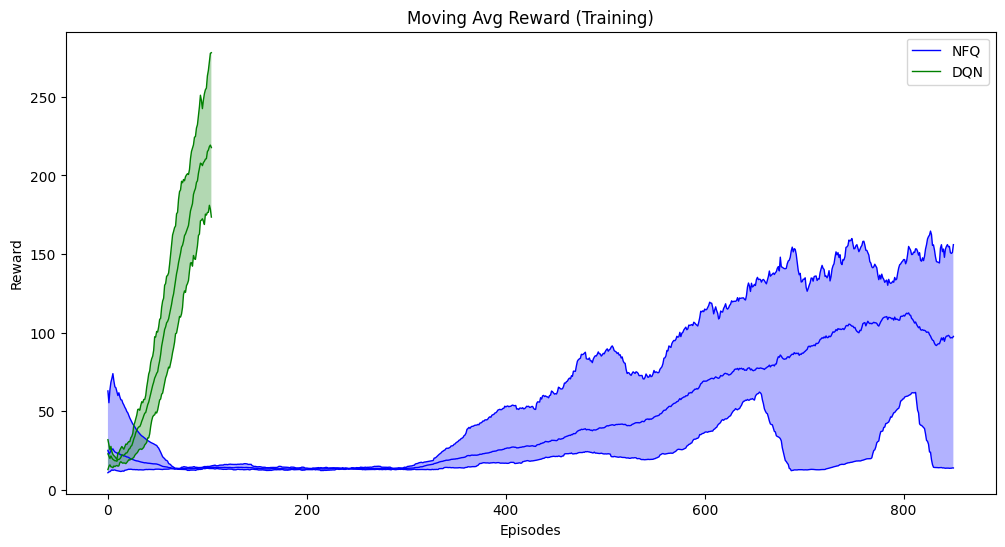

In [24]:
show_result('avg_training_reward','NFQ', nfq_results, 'DQN', dqn_results) 

We can plot the average reward obtained in evaluation for each episode. Notice that both algorithms pass the cartpole environment, but DQN takes approximately one order of magnitude less episodes to do so. Again, this is because DQN is more sample efficient than NFQ.  


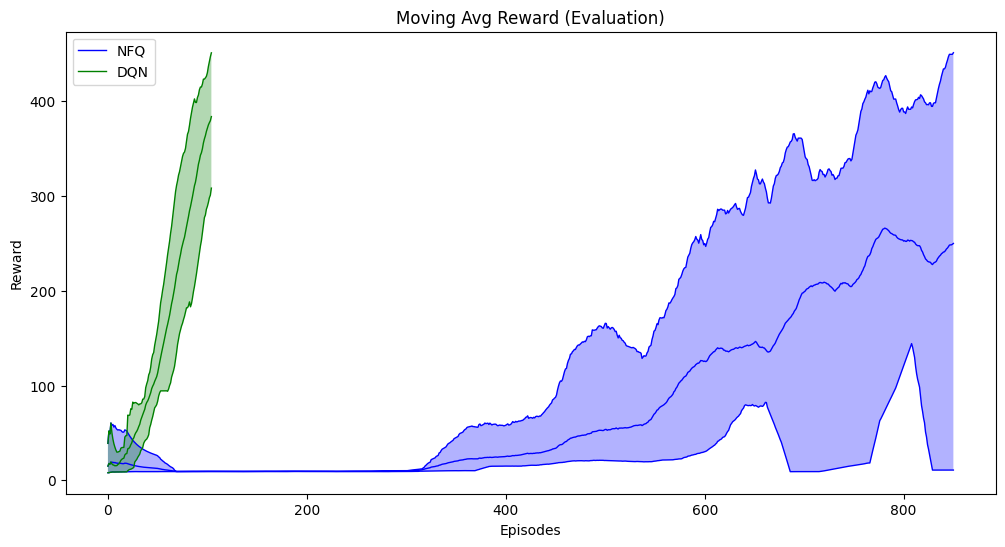

In [25]:
show_result('avg_evaluation_reward','NFQ', nfq_results, 'DQN', dqn_results) 

We can plot the total number of steps to see a similar trend in sample efficiency:

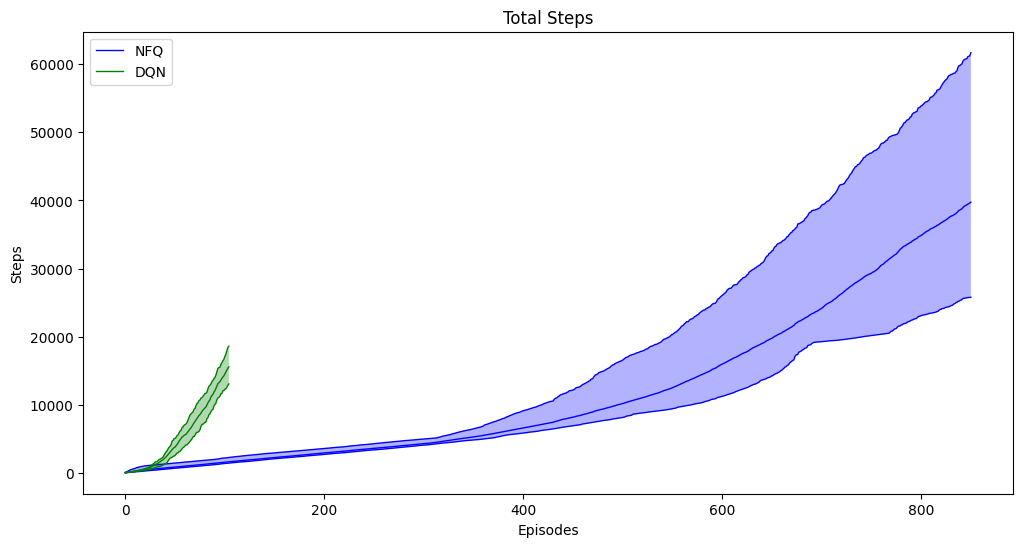

In [26]:
show_result('total_steps','NFQ', nfq_results, 'DQN', dqn_results) 

Finally, we can plot the training time for each episode. Notice that DQN is slower than NFQ, this is because we need to sample a batch from the replay buffer and sometimes we need to synchronize the target network with the online network. However, the training time is still reasonable.

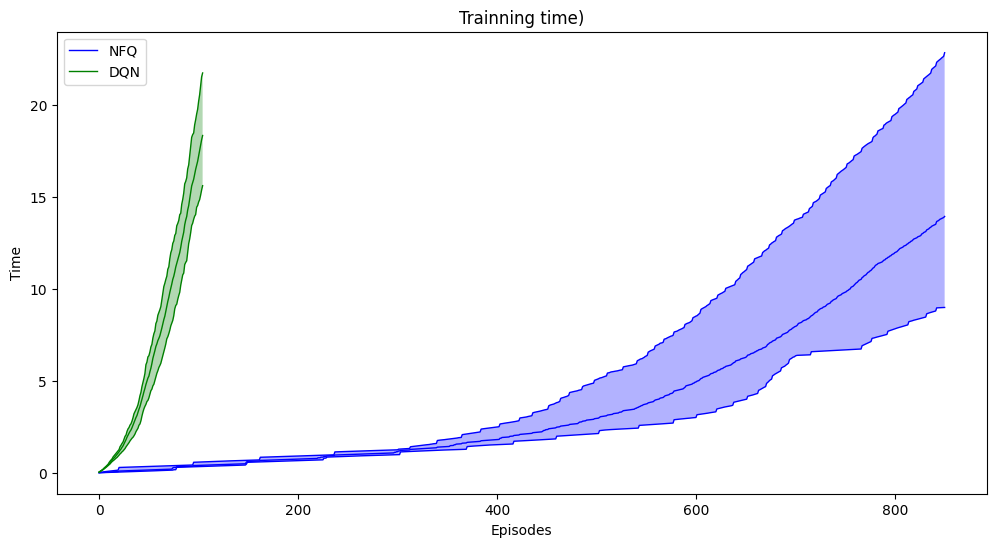

In [27]:
show_result('training_time','NFQ', nfq_results, 'DQN', dqn_results) 

We can show the best learned policy for DQN:

In [28]:
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from itertools import count

def show_policy(env, agent, n_episodes=1, max_steps=500):
    for episode in count():

        state = env.reset()[0]

        for step in count():

            if(agent is None):
                action = np.random.choice((0, 1))
            else:
                action = greedy(agent, state)
            
            state, reward, is_terminal, is_truncated, info = env.step(action)
            done = is_terminal or is_truncated
            
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.show()
            
            if done or step > max_steps:
                break

        if episode >= n_episodes-1:
                break

env = gymnasium.make('CartPole-v1', render_mode="rgb_array")

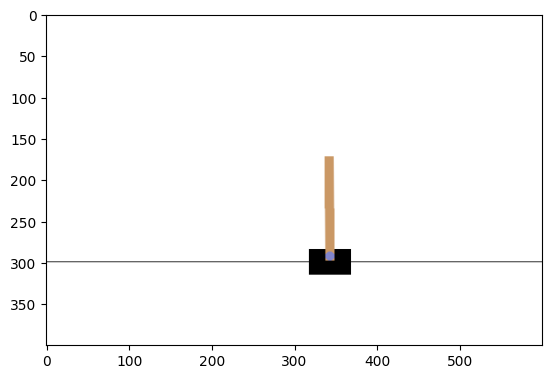

In [ ]:
show_policy(env, dqn_agent, max_steps=100)

## Double Q-Learning (DDQN)

In general, Q-learning **tends to overestimate action-value functions**, and the DQN agent is no different. We use the same off-policy TD target with the max operator, and taking the max of estimats (which are are often off-center) creates a **positive bias** and performance suffers. One way to better understand this positive bias and how we can address it is by unwrapping the max operator in the target calculations. Notice that the max of a Q-function is the same as the Q-function of the argmax action:

$\displaystyle
\underset{a}{\text{ max }} Q(s',a;\theta^-) = Q(s',\underset{a}{\text{argmax }} Q(s',a;\theta^-);\theta^-) $

so we can modify the loss expression as

$\displaystyle L(\theta) = E_{(s,a) \sim U(D)} \left[ ( r + \gamma \text{ }Q(s',\underset{a}{\text{argmax }} Q(s',a;\theta^-);\theta^-) - Q(s,a;\theta))^2 \right] $

There’s no real difference between the two equations, since both are using the same Q-values for the target. All we’re saying here is that taking the max is like asking the network "What’s the value of the highest-valued action in state s?" But, we are really asking two questions with a single question. First, we do an argmax, which is equivalent to asking, "Which action is the highest-valued action in state s?" and then, we use that action to get its value, equivalent to asking, "What’s the value of this action in state s?" One of the problems is that **we are asking both questions to the same Q-function, which shows bias in the same direction in both answers**. In other words, the function approximator will answer, "I think this one is the highest-valued action in state s, and this is its value". 

An idea to reduce the chance of positive bias is to have **two instances of the action-value function** ([van Hasselt et al. **"Deep Reinforcement Learning with Double Q-learning"** (2015) AAAI Conference](https://arxiv.org/abs/1509.06461v3)), so we can ask one of the questions to one and the other question to the other. It’s somewhat like getting a second doctor’s opinion on health matters. In double learning, **one estimator selects the index of what it believes to be the highest-valued action, and the other estimator gives the value of this action**.

Implementing this procedure creates **unnecessary overhead** (we end up with four networks, two for training and two target networks) and it creates a **slowdown in the training process** (since we’d be training only one of these networks at a time). Fortunately, there’s a simple modification to the original double-learning procedure that adapts it to DQN and gives us substantial improvements without the extra overhead: **we can perform double learning with the other network we already have, which is the target network**. We use the online network (the network we’re training) for answering the first question (to find the index of the best action), then we use the target network to ask the second question (evaluate the selected action):

<img src="./images/ddqn.png" width="600">

So, the only difference in DDQN is that now we use the online weights to select the action, but still use the frozen weights to get the estimate:

$\displaystyle L(\theta ) =E_{(s,a) \sim U(D)} \left[ ( r + \gamma \text{ } Q(s',\underset{a}{\text{argmax }} Q(s',a;\theta);\theta^-) - Q(s,a;\theta))^2 \right] $

In [30]:
def optimize(memory, online_model, target_model, optimizer, gamma):

    # sample a mini batch of transition from the replay buffer
    states, actions, rewards, next_states, is_failures = memory.sample()
    
    states = torch.from_numpy(np.vstack(states)).float()
    actions = torch.from_numpy(np.vstack(actions)).long()
    next_states = torch.from_numpy(np.vstack(next_states)).float()
    rewards = torch.from_numpy(np.vstack(rewards)).float().float()
    is_failures = torch.from_numpy(np.vstack(is_failures)).long()
        
    # get the online model and target model predictions for the next state
    # remember to detach because this part is fixed and should not be part 
    # of the gradient calculation
    q_online_next = online_model(next_states).detach()
    q_target_next = target_model(next_states).detach()

    # get the best actions according to the online model
    best_actions = q_online_next.max(1)[1].unsqueeze(1)

    # get the value estimations of the best actions from the target model
    max_q_target_next = torch.gather(q_target_next, 1, best_actions) * (1 - is_failures)

    # calculate the target 
    target = rewards + gamma * max_q_target_next

    # get the current estimate of the value of the current state and action
    # from the online model 
    q_online_current = torch.gather(online_model(states), 1, actions)

    # create the errors
    td_errors = target - q_online_current
    
    # calculate the loss, and optimize the online network
    value_loss = td_errors.pow(2).mean()

    optimizer.zero_grad()
    value_loss.backward()
    optimizer.step()

    return value_loss.detach().numpy()

We setup the experiment with the same parameters of DQN. However, we use RMSprop with a learning rate of 0.0007. Note that before we used 0.0005 because without double learning, several seeds fail if we train with a learning rate of 0.0007. Perhaps stability? In DDQN, on the other hand, training with a higher learning rate works best.

In [31]:
ddqn_results, ddqn_agent, ddqn_score = run_experiment(name = 'ddqn_results')

episode 0169, total steps 027229, average score 454.1  --> reached max score 
episode 0139, total steps 024412, average score 453.5  --> reached max score 
episode 0098, total steps 016093, average score 455.3  --> reached max score 
episode 0138, total steps 024954, average score 455.2  --> reached max score 
episode 0095, total steps 014733, average score 451.5  --> reached max score 


DQN and DDQN have similar performance in the cart-pole environment. However, this is a simple environment with a smooth reward function. In reality, DDQN should always give better performance than DQN in a more evident way.

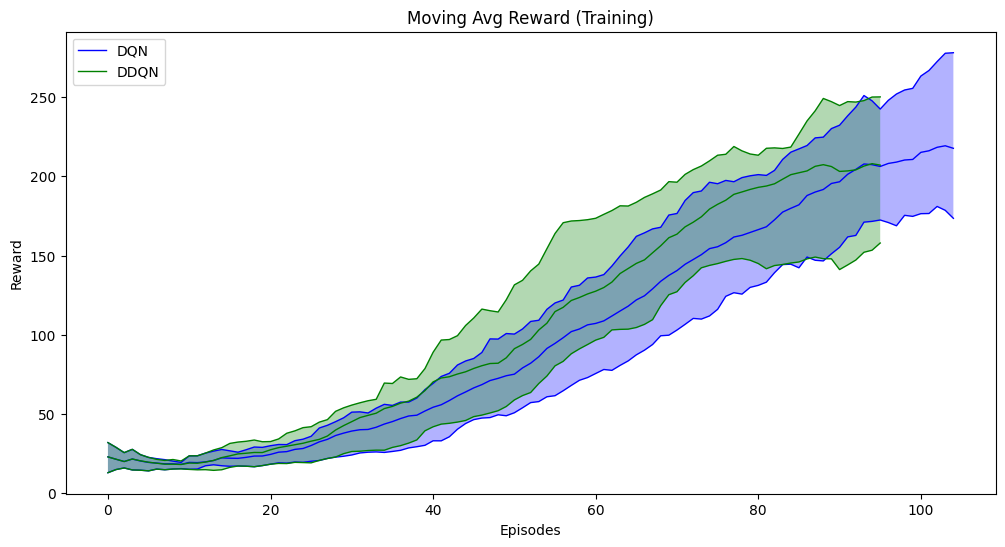

In [32]:
show_result('avg_training_reward','DQN', dqn_results, 'DDQN', ddqn_results) 

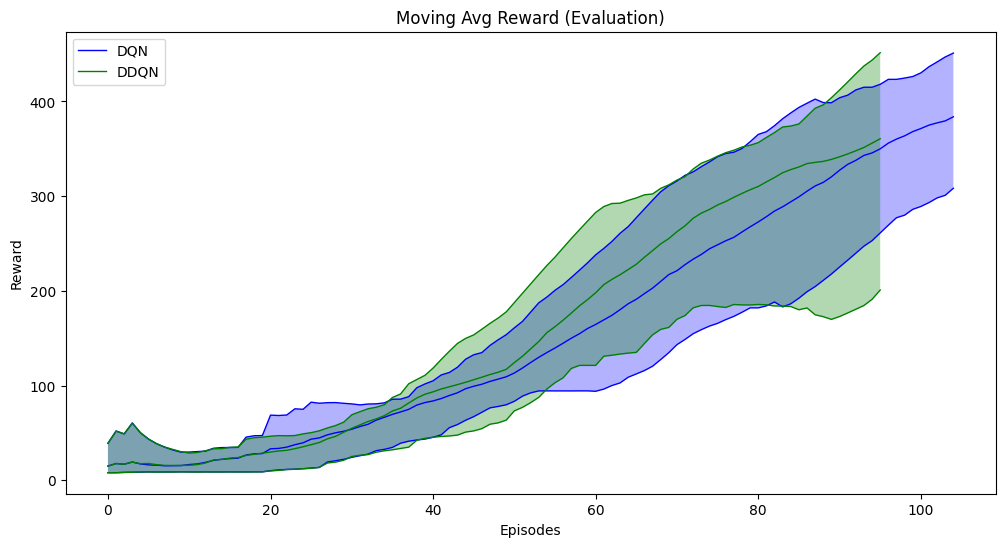

In [33]:
show_result('avg_evaluation_reward','DQN', dqn_results, 'DDQN', ddqn_results) 

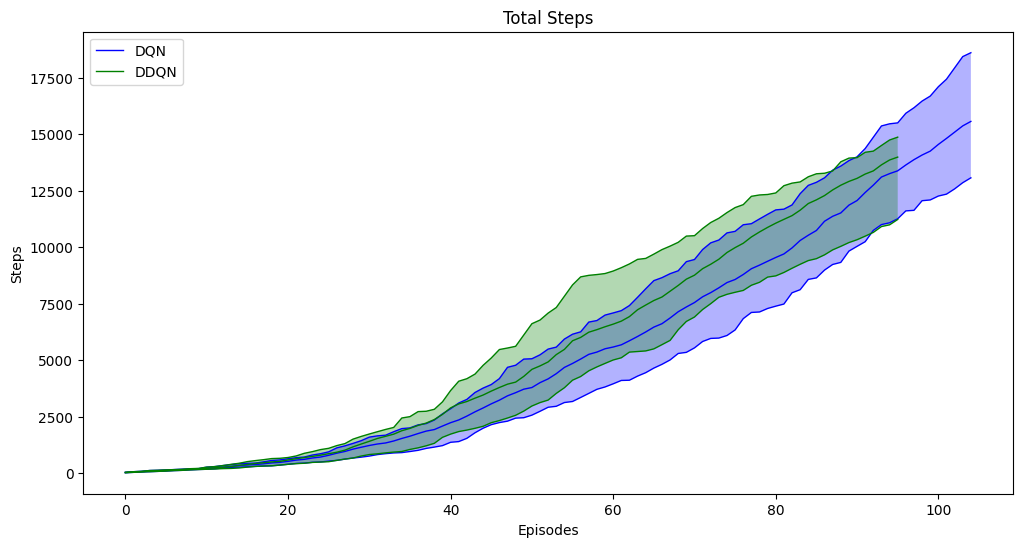

In [34]:
show_result('total_steps','DQN', dqn_results, 'DDQN', ddqn_results) 

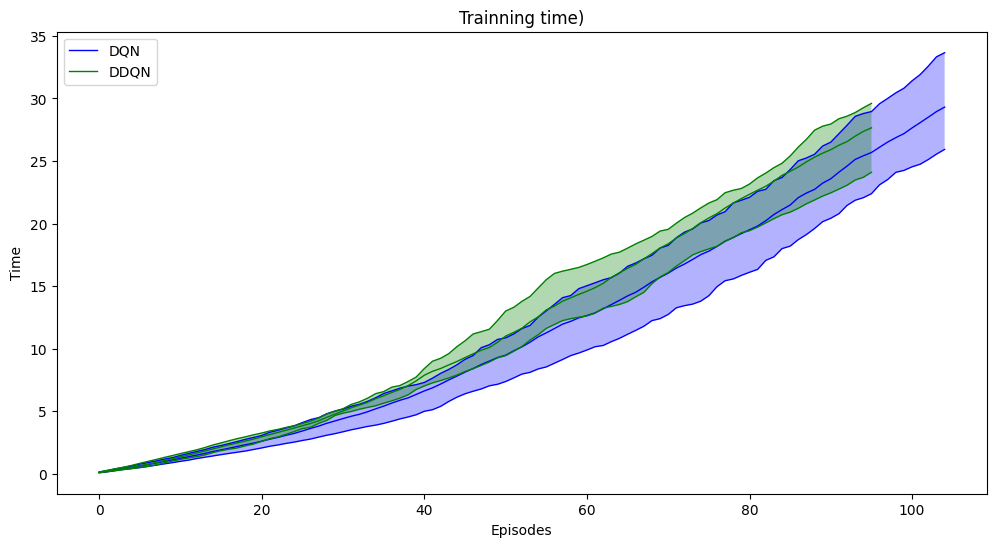

In [136]:
show_result('training_time','DQN', dqn_results, 'DDQN', ddqn_results) 

## Dueling Architecture

The dueling network is an improvement that applies to the **network architecture** and not the algorithm. Until now, we concentrated our efforts on making reinforcement learning **look more like a supervised learning problem**: using the replay memory we made data more like an independent and identically distributed dataset; using two networks we made targets look more static. This helps stabilize training, but ignoring the fact that reinforcement learning problems are problems of their own isn’t the smartest approach to solving these problems.

Now we try to exploit the subtleties of value-based deep reinforcement learning agents, in particular the way the value functions relate to one another. More specifically, we can use the fact that the state-value function V and the action-value function Q are related to each other through the **action-advantage function** A:

$\displaystyle v_{\pi}(s) = E_{\pi}[G_t | S_t=s] $

$\displaystyle q_{\pi}(s,a) = E_{\pi}[G_t | S_t=s, A_t=a] $

we can define the **action-advantage function** as the **difference between the value of taking an action in a state and the value of choosing the policy action**:

$\displaystyle a_{\pi}(s,a) = q_{\pi}(s,a) - v_{\pi}(s) $

We can rewrite this and observe that the action-value function can be defined as the sum of the state-value function and the action-advantage function. This means that we can decompose the action-value function into two components: **one shared across all actions, and another unique to each action**:

$\displaystyle q_{\pi}(s,a) = v_{\pi}(s) + a_{\pi}(s,a) $


This means that we’re learning the action-value function inefficiently, because **some information is shared between the nodes of a network**. However, when learning about the action-value of an action, we’re ignoring the fact that we could use the same information to learn something about all other actions:

<img src="./images/dueling.png" width="800">

The bottom line is that **the values of actions depend on the values of states**, and it would be nice to leverage this fact. In the end, taking the worst action in a good state could be better than taking the best action in a bad state. Considering the following example from cart-pole to better understand the importance of the action-advantage function:

<img src="./images/action-advantage.png" width="800">


The **dueling network architecture** ([Ziyu et al. **Dueling Network Architectures for Deep Reinforcement Learning**, ICML 2016](https://arxiv.org/abs/1511.06581)) consists of creating two separate estimators: one of the state-value function, and the other of the action-advantage function. We can use a single network sharing most of the internal nodes and layers, the layer before the output splits into two streams: a stream for the state-value function and another for the action-advantage function. The V-function output layer always ends in a single node because the value of a state is always a single number, the output layer for the Q-function, however, outputs a vector of the same size as the number of actions:

<img src="./images/dueling-network.png" width="800">

Now, we need to find a way to **aggregate the two outputs from the network** and reconstruct the action-value function. How do we join the outputs? Some of you are thinking, add them up, right?  The Q-function is parameterized by theta (weights of the shared layers), alpha (weights of the action-advantage function stream), and beta (weights of the state-value function stream):

$\displaystyle Q(s,a;\theta,\alpha,\beta) = V(s;\theta,\beta) + A(s,a;\theta,\alpha) $

However, notice that we cannot uniquely recover the Q from V and A (think about it: if we add +10 to V and remove it from A we obtain the same Q with two different values for V and A), we use the above equation in practice. The way to address this issue is by subtracting the mean of the advantages from the aggregated action-value function estimate. Doing this stabilizes the optimization process:

$\displaystyle Q(s,a;\theta,\alpha,\beta) = V(s;\theta,\beta) + \left( A(s,a;\theta,\alpha) - \frac{1}{|A|}\sum\limits_{a'}{A(s,a;\theta,\alpha)} \right) $

In [144]:
import torch

class Approximator(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(Approximator, self).__init__()

        # activation function (ReLU)
        self.activation = torch.nn.functional.relu

        # input layer
        self.input_layer = torch.nn.Linear(state_size, 512)
        
        #  hidden layer
        self.hidden_layer = torch.nn.Linear(512, 128)

        # finally, we build the two output layers, both connected to the last hidden layer 

        # the value_output has a single node output 
        self.value_output = torch.nn.Linear(128, 1)
       
        # the advantage_output has output_dim nodes
        self.advantage_output = torch.nn.Linear(128, action_size)

    def forward(self, state):

        # convert the state into a tensor
        if not isinstance(state, torch.Tensor):
            state = torch.Tensor(state)

        # pass it through the input layer
        x = self.activation(self.input_layer(state))

        # then pass hidden layer
        x = self.activation(self.hidden_layer(x))

        # then pass for the advantage_output and the value_output layers. 
        a_values = self.advantage_output(x)
        v_values = self.value_output(x)
        
        # finally, add v and a and subtract the mean of a from it
        q_values = v_values + (a_values - a_values.mean())
        
        return q_values

    def select_action(self, state):
        
        # convert the state into a tensor
        state = torch.FloatTensor(state).unsqueeze(0)
        
        # calculate q_values from the network
        q_values = self(state).detach()

        # act greedy
        action = np.argmax(q_values).data.numpy()
        return action

The rest of the architecture of the Dueling DDQN is almost identical to DDQN: the network outputs the action-value approximation, an off-policy TD target is used to evaluate policies, the loss is evaluated with the Huber formula, a replay memory is used to learning from past experiences, the optimizer is the RMSprop, an exponentially decaying epsilon-greedy strategy is used to improve policies and a greedy action selection strategy for the evaluation step.

However, the **DDQN agent use a target network that can be outdated for several steps before it gets a weight update** when syncing with the online network. There are a couple of issues with this approach: on the one hand, we’re freezing the weights for several steps and calculating estimates with progressively increasing stale data; on the other hand, a huge update is made to the network, making a big update that changes the whole landscape of the loss function all at once. **This update style seems to be both too conservative and too aggressive at the same time**. Of course, we got into this issue because we wanted our network not to move too quickly and therefore create instabilities.

We can have similar results, but in a smooth manner: we can **slow down the target network instead of freezing it**. This technique is called **Polyak Averaging**, and it consists of mixing online network weights into the target network on every step. We create a new target network composed of a large percentage of the target network weights and a small percentage of the online network weights. In that way, the target network always lags, but by a much smaller gap.

So, instead of making the target network equal to the online network every N time steps, we mix the target network with a tiny bit of the online network more frequently (even every time step):

$\displaystyle \theta_i^- = \tau \theta_i + (1-\tau)\theta_i^- $

$\displaystyle \alpha^- = \tau \alpha_i + (1-\tau)\alpha_i^- $

$\displaystyle \beta_i^- = \tau \beta_i + (1-\tau)\beta_i^- $

where $\tau$ is the **mixing factor**.

In [138]:
def update(target_model, online_model, tau=0.1):  
        
    for target, online in zip(target_model.parameters(), online_model.parameters()):
        # calculate the ratios we’re taking from the target and online weights
        target_ratio = (1.0 - tau) * target.data
        online_ratio = tau * online.data
        
        # mix the weights and copy the new values into the target network 
        mixed_weights = target_ratio + online_ratio
        target.data.copy_(mixed_weights)

Dueling DDQN and DDQN have similar performance in the cart-pole environment. Dueling DDQN is slightly more data efficient. The number of samples DDQN needs to pass the environment is higher than that of dueling DDQN. However, dueling DDQN takes slightly longer than DDQN.

In [145]:
dueling_ddqn_results, dueling_ddqn_agent, dueling_ddqn_score = run_experiment(name = 'dueling_ddqn_results')

episode 0145, total steps 024796, average score 453.3  --> reached max score 
episode 0136, total steps 021584, average score 450.3  --> reached max score 
episode 0240, total steps 042932, average score 450.7  --> reached max score 
episode 0370, total steps 052921, average score 454.0  --> reached max score 


KeyboardInterrupt: 

Dueling DDQN and DDQN have similar performance in the cart-pole environment. Dueling DDQN is **slightly more data efficient**. The number of samples DDQN needs to pass the environment is higher than that of dueling DDQN.

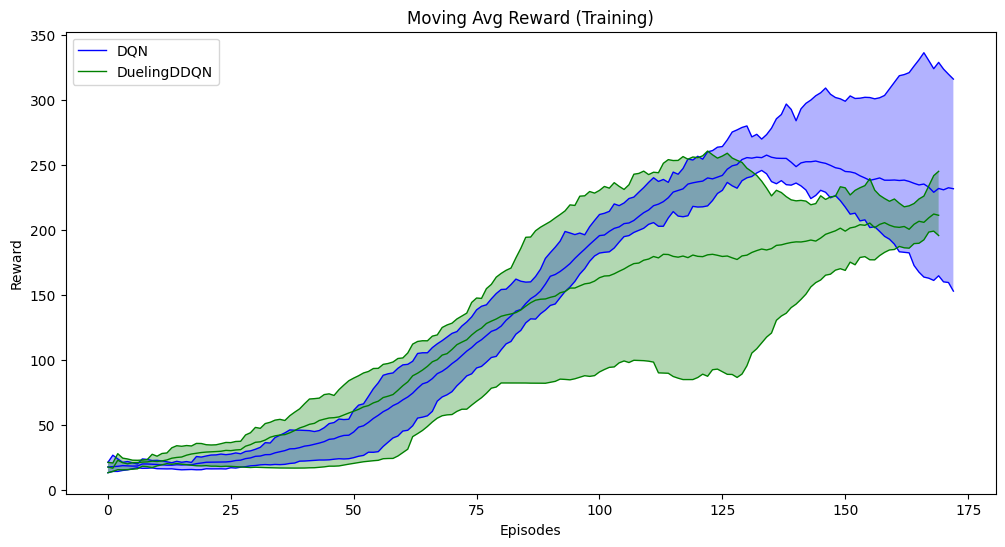

In [ ]:
show_result('avg_training_reward','DQN', dqn_results, 'DuelingDDQN', dueling_ddqn_results) 

The evaluation plot shows the same pattern.

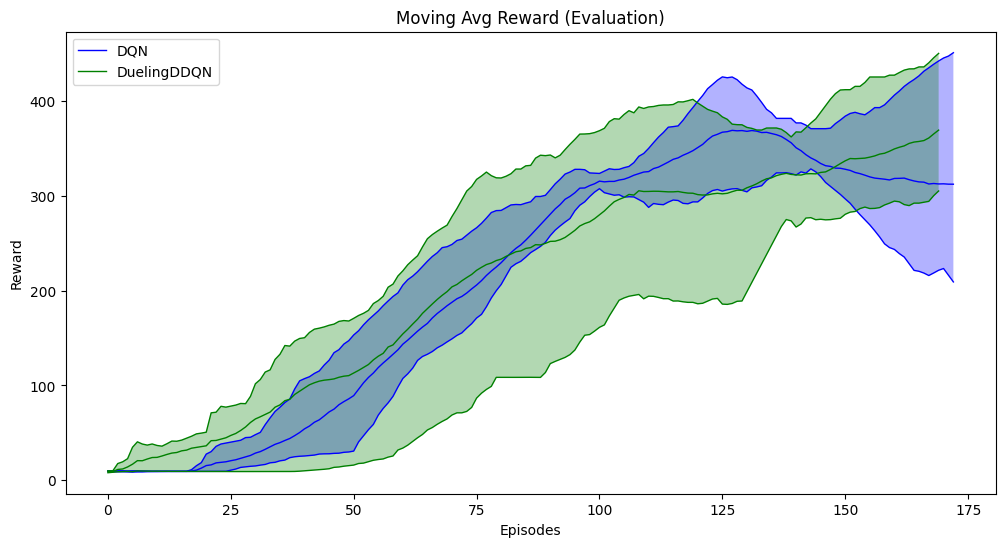

In [ ]:
show_result('avg_evaluation_reward','DQN', dqn_results, 'DuelingDDQN', dueling_ddqn_results) 

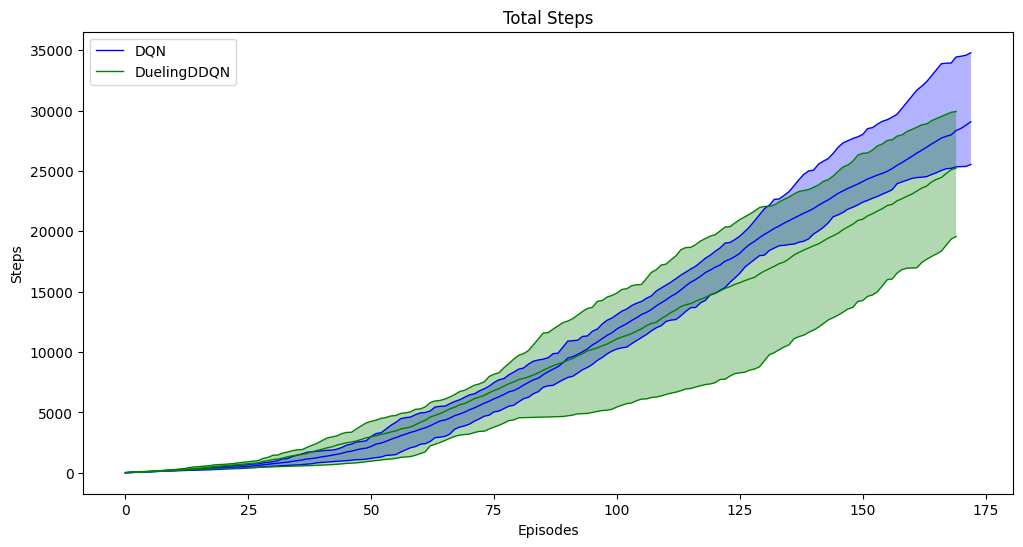

In [ ]:
show_result('total_steps','DQN', dqn_results, 'DuelingDDQN', dueling_ddqn_results) 

Dueling DQN takes longer to train. Maybe because we’re now updating the target network every time step? Maybe the dueling network?

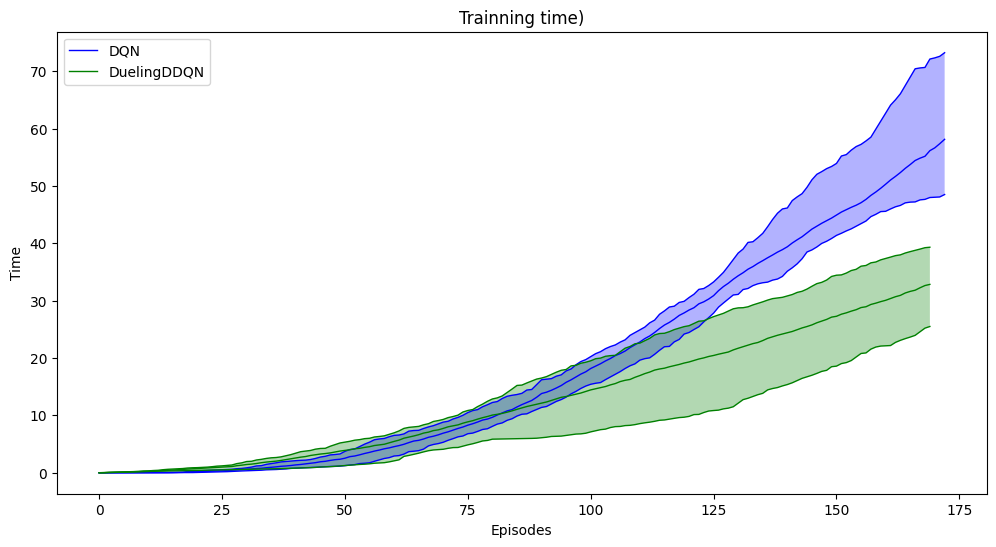

In [ ]:
show_result('training_time','DQN', dqn_results, 'DuelingDDQN', dueling_ddqn_results) 

## Prioritized Experience Replay (PER)

The agent samples experience tuples from the replay memory uniformly at random. Intuitively, this seems like an inferior way of replaying experiences. It doesn’t feel right that the agent spends time and compute power "learning" things that have nothing to offer to the current state of the agent. But, while this is evident, more difficult is determining a different sampling behavior. We can think that since the agent has to get the highest cumulative discounted rewards possible, we can replay experiences with high reward only. However, this obvious approach didn’t work. The agent needs also other types of experiences! What we’re looking for is **to learn from experiences with unexpected value (surprising experiences)**. The agent has a view of the world, he anticipates outcomes, and when the difference between expectation and reality is significant, we know he can learn something from that! In reinforcement learning, this **measure of surprise** is given by the TD error: it provides the difference between the agent’s current estimate and target value. The absolute difference between these values **indicates how unexpected this experience is**, and how much new information the agent receives, which makes it a good indicator for learning opportunity ([Tom Schaul et al. **Prioritized Experience Replay** ICLR 2016](https://arxiv.org/abs/1511.05952?context=cs)):

$\displaystyle |\delta| = |r + \gamma \text{ } Q(s', \underset{a}{\text{argmax }}\text{ } Q(s',a;\theta );\theta^-)-Q(s,a;\theta) $

We can  **insert experience into the replay memory as a tuple containing also to the TD error**, so then we can pull out the top experiences from the buffer **sorting** by this new value. However there two issues with this approach: first, we are calculating the TD errors twice (before inserting it into the memory, and then again when we train the network); second we’re ignoring the fact that TD errors change every time the network changes, because they’re calculated using the network. The solution can’t be updating all of the TD errors every time step, it’s simply not cost effective.

A workaround for both these problems is to **update the TD errors only for experiences that are used to update the network (the replayed experiences)** and insert new experiences with the highest magnitude TD error in the memory. However, other issues arise: a TD error of zero in the first update means that experience will likely never be replayed again, moreover when using function approximator, errors shrink slowly, and this means that updates concentrate heavily in a small subset of the replay memory. For these reasons, we need a strategy for sampling experiences based on the TD errors, but **stochastically, not greedily**: in that way we can simultaneously ensure all experiences have a chance of being replayed, and that the probabilities of sampling experiences are monotonic in the absolute TD error.

First we calculate priorities for each sample $i$ in the buffer based on TD errors:

$\displaystyle p_i = |\delta_i| + \epsilon $

we add a small constant, epsilon, to make sure zero TD error samples still have a chance of being replayed. Then, we scale the priority by exponentiating it to a hyperparameter alfa that allows us to interpolate between uniform and prioritized sampling:

$\displaystyle P(i)=\frac{p_i^\alpha}{\sum\limits_{k}{p_k^\alpha} } $

When alpha is zero, all values become one, therefore, an equal priority; when alpha is one, all values stay the same as the absolute TD error; a value in between blends the two sampling strategies. The scaled priorities are converted to actual probabilities by dividing by the sum of the values. One issue with this approach is that it’s sensitive to outliers. That means experiences with much higher TD error than the rest (whether by fact or noise) are sampled more often than those with low magnitudes, which may be an undesired side effect.

Another problem is that the prioritization introduces a form of **sampling bias toward high-priority samples** (more chances to be selected). With prioritization we are not uniformly sampling from the replay memory and we start over-sampling those with high priority. We must compensate for this bias during training or the model will just overfit the important experiences. To be clear, **we want important experiences to be sampled more often, but this also means we must give them a lower weight during training**. The way to mitigate this bias is to use a technique called **weighted importance sampling**: it consists of scaling the TD errors by weights calculated with the probabilities of each sample. We can calculate the importance-sampling weights by multiplying each probability by the number N of samples in the replay buffer:

$\displaystyle w_i = \left(\frac{1}{N} \frac{1}{P_i}\right)^\beta $

we add the beta hyperparameter to tune the degree of the corrections. When beta is zero, there’s no correction; when beta is one, there’s a full correction of the bias. Training is highly unstable at the beginning, so the importance sampling corrections matter more near the end of training. Thus, beta starts small (values of 0.4 to 0.6 are commonly used) and anneals towards one.

Additionally, we want to normalize the weights by their max so that the max weight becomes one, and all other weights scale down the TD errors. This way, we keep TD errors from growing too much and keep training stable:

$\displaystyle w_i = \frac{w_i}{\text{max }(w_j)} $

In [ ]:
class ReplayMemory():
    def __init__(self, memory_size, batch_size):
        self.memory_size = memory_size
        self.batch_size = batch_size

        self.states = np.empty(shape=(memory_size, 4), dtype=np.float32)
        self.actions = np.empty(shape=(memory_size), dtype=np.int8)
        self.rewards = np.empty(shape=(memory_size), dtype=np.float32)
        self.next_states = np.empty(shape=(memory_size, 4), dtype=np.float32)
        self.is_failures = np.empty(shape=(memory_size), dtype=np.int8)
        self.priorities = np.empty(shape=(memory_size), dtype=np.float32)
        
        self.n_entries = 0
        self.next_index = 0

        self.alpha = 0.4
        self.beta = 0.4

    def store(self, state, action, reward, next_state, is_failure):
        
        # calculate the priority for the sample using
        # the highest magnitude TD error in the memory
        priority = 1.0
        if self.len() > 0:
            priority = self.priorities[:self.len()].max()

        # insert the sample and its priority into the memory
        self.states[self.next_index] = state
        self.actions[self.next_index] = action
        self.rewards[self.next_index] = reward
        self.next_states[self.next_index] = next_state
        self.is_failures[self.next_index] = is_failure
        self.priorities[self.next_index] = priority
        
        self.n_entries = min(self.n_entries + 1, self.memory_size)
        self.next_index += 1
        self.next_index = self.next_index % self.memory_size

    
    def update(self, idxs, td_errors):
        # takes the array of experiences ids, and new TD error values
        # insert the absolute TD errors into the right place.
        self.priorities[idxs] = np.abs(td_errors)

    def sample(self, batch_size=None):
        batch_size = self.batch_size if batch_size == None else batch_size
        if(batch_size > self.len()): raise Exception("Batch size is greater than the memory size")
      
        # go from priorities to probabilities
        priorities = self.priorities[:self.len()] + 1e-6
        scaled_priorities = priorities ** self.alpha               

        probs = scaled_priorities / np.sum(scaled_priorities)
        
        # calculate the importance-sampling weights using the probabilities
        weights = (self.len() * probs) ** -self.beta
        weights = weights/weights.max()

        # sample experiences in the memory using the probabilities
        idxs = np.random.choice(self.len(), batch_size, replace=False, p=probs)

        weights = weights[idxs]
        states = self.states[idxs]
        actions = self.actions[idxs]
        rewards = self.rewards[idxs]
        next_states = self.next_states[idxs]
        is_failures = self.is_failures[idxs]

        return idxs, weights, states, actions, rewards, next_states, is_failures

    def len(self):
        return self.n_entries

These importance-sampling weights are used in the loss function. Instead of using the TD errors straight, we multiply them by the importance-sampling weights: 

$\displaystyle L(\theta)=E_{(s,a) \sim P(D)} \left[ w ( r + \gamma \text{ } Q(s',\underset{a}{\text{argmax }} Q(s',a;\theta);\theta^-) - Q(s,a;\theta))^2 \right] $

Notice how we’re using the normalized importance-sampling weights to modify the magnitude of the TD error, and that we changed the "U" for a "P", because we’re doing a prioritized sampling, and not uniformly at random.

In [ ]:
def optimize(memory, online_model, target_model, optimizer, gamma):

    # sample a mini batch of transition from the replay buffer
    idxs, weights, states, actions, rewards, next_states, is_failures = memory.sample()

    weights = torch.from_numpy(np.vstack(weights)).float()
    states = torch.from_numpy(np.vstack(states)).float()
    actions = torch.from_numpy(np.vstack(actions)).long()
    next_states = torch.from_numpy(np.vstack(next_states)).float()
    rewards = torch.from_numpy(np.vstack(rewards)).float().float()
    is_failures = torch.from_numpy(np.vstack(is_failures)).long()
        
    # get the best action for the next state from the online model 
    q_online_next = online_model(next_states).detach()
    argmax_q_online_next = q_online_next.max(1)[1].unsqueeze(1)

    # get the values of that action from the target model
    q_target_next = target_model(next_states).detach()
    max_q_target_next = q_target_next.gather(1, argmax_q_online_next)
    max_q_target_next *= (1 - is_failures)

    # calculate the target 
    target = rewards + gamma * max_q_target_next

    # finally, we get the current estimate of Q(s,a), here we query the current "online" network
    q_online_current = online_model(states).gather(1, actions)
    
    # create the errors
    td_errors = target - q_online_current

    # calculate the loss, and optimize the online network
    # now the loss function has TD errors downscaled by the weights
    value_loss = (weights * td_errors).pow(2).mul(0.5).mean()

    optimizer.zero_grad()
    value_loss.backward()
    optimizer.step()

    # update the priorities of the replayed batch using the absolute TD errors
    priorities = np.abs(td_errors.detach().numpy())
    memory.update(idxs, priorities.squeeze())

Again, we can improve all value-based deep reinforcement learning methods usgin the improved  replay mempry. Most of the thing are still as before (network architecture, tartget, loss function, optimizer, exploration strategy, polyak avereging), however this time we use weighted important sampling to adjust the TD errors (which changes the loss function) and a prioritized replay buffer with proportional prioritization:

In [ ]:
per_ddqn_results, per_ddqn_agent, per_ddqnn_score = run_experiment(name = 'per_ddqn_results', target_update_steps = 1)

TypeError: ReplayMemory.__init__() takes 3 positional arguments but 4 were given

The prioritized replay buffer uses fewer samples than any of the previous methods. And as you can see it in the graphs below, it even makes things look more stable. But look at this! PER is much slower than dueling DDQN. But know that this is an implementation-specific issue. If you get a high quality implementation of PER, this shouldn’t happen.

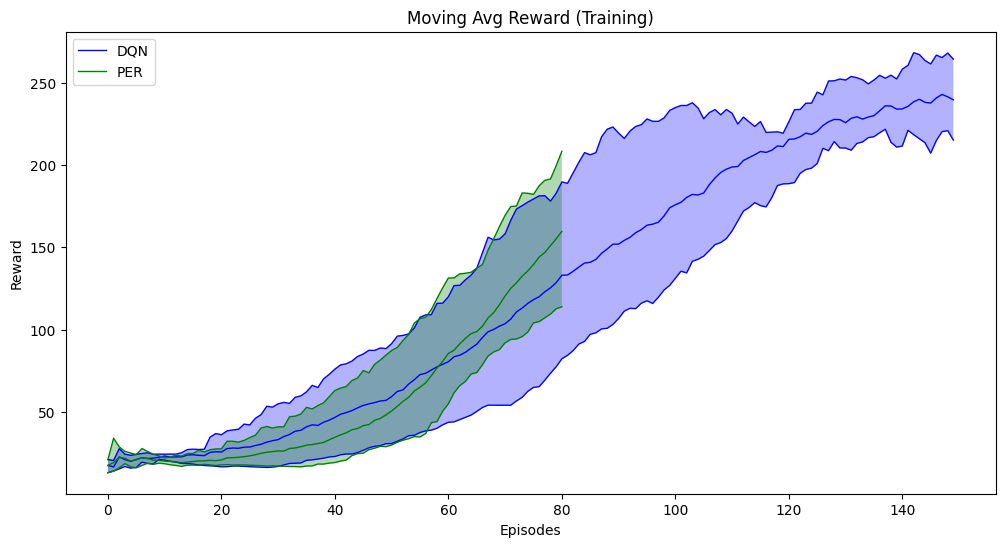

In [ ]:
show_result('avg_training_reward','DQN', dqn_results, 'PER', per_ddqn_results) 

Nothing really different in the evaluation plot in terms of sample complexity, but you can also see a bit more stability than previous methods.

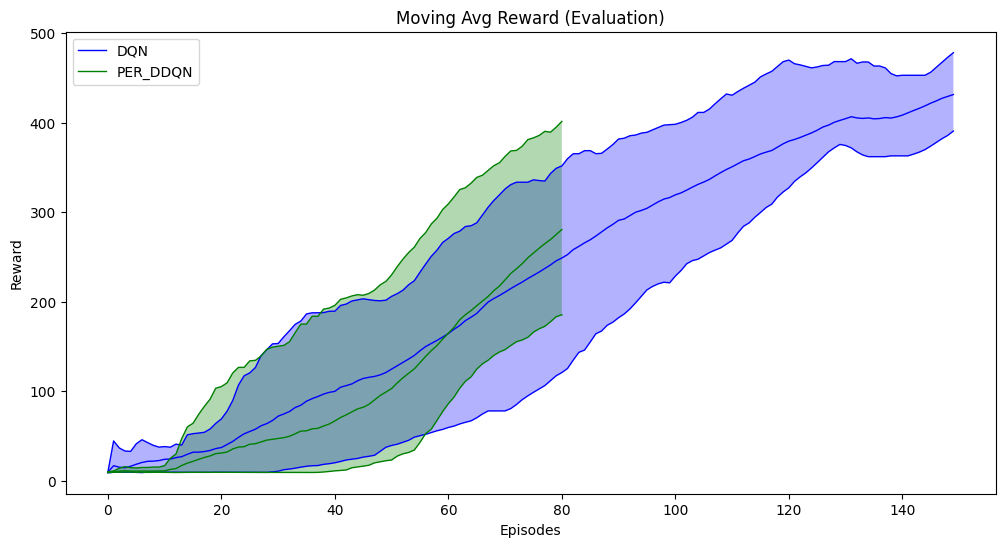

In [ ]:
show_result('avg_evaluation_reward','DQN', dqn_results, 'PER_DDQN', per_ddqn_results) 

The real indication of sample complexity is the number of steps, not episodes, because episodes contain a variable number of steps in this environment. However, the pattern is the same. PER is more sample efficient than all previous methods

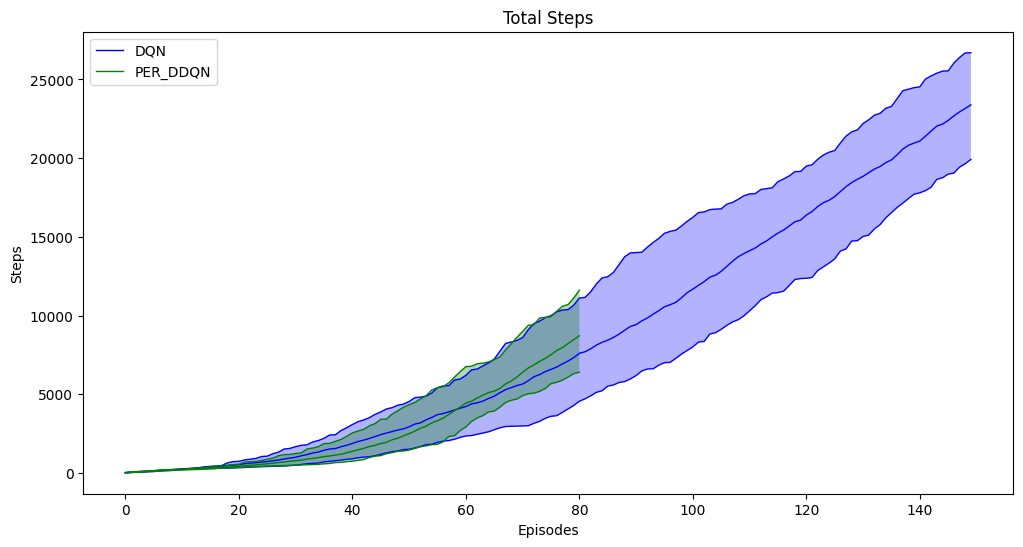

In [ ]:
show_result('total_steps','DQN', dqn_results, 'PER_DDQN', per_ddqn_results) 

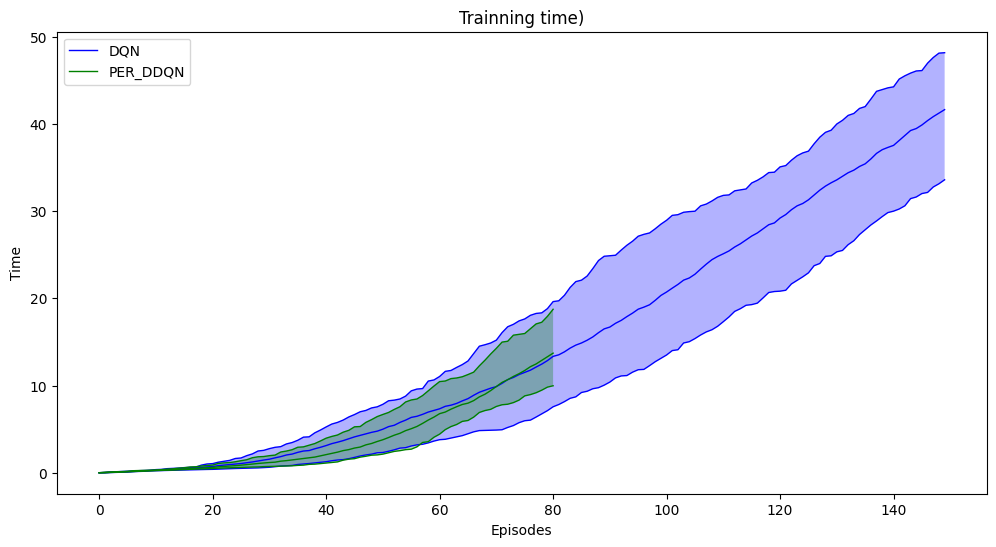

In [ ]:
show_result('training_time','DQN', dqn_results, 'PER_DDQN', per_ddqn_results) 

## Challenges

All of those improvements can be combined together in several different ways in order to improve the performance of the agent. For example the **Rainbow algorithm** ([Hessel et al. **"Rainbow: Combining Improvements in Deep Reinforcement Learning"**, AAAI, 2017](https://arxiv.org/abs/1710.02298)) combines all of the components we’ve seen so far (Double DQN, Dueling DQN, Prioritized Experience Replay) and others (Noisy Nets, Distributional DQN, and Categorical DQN) in order to achieve better performance and stability.

However, Value-based methods are **sensitive to hyperparameters**. Try it for yourself: change any hyperparameter. You can find more values that don’t work than values that do. Second, value-based methods **assume they interact with a Markovian environment**, that the states contain all information required by the agent. This assumption dissipates as we move away from bootstrapping and value-based methods in general. 

Last, **the combination of bootstrapping, off-policy learning, and function approximator** are known conjointly as **the deadly triad**: it is known to produce **divergence**, researchers still don’t know exactly how to prevent it. A practical advice is to use target networks, replay buffers, double learning, sufficiently small learning rates (but not too small), and maybe a little bit of patience.